# Assignment 1 - Simulating Free Particles in One Dimension Modified

Problem statement: The code from the first week of class modeled a 1-dimensional system with two particles, elastic collisions, and reflecting boundaries. I have modified this code to include many particles(n_particles) and vanishing boundaries. Note that I used ChatGPT to debug some code and to make animated plots of the trajectories. This modified model more closely represents the water channel/carbon nanotube problem described in the original notebook. Where water molecules are passing through a channel, and can escape the channel, with the goal of measuring: how long it would take for all the water molecules to exit the channel/nanotube? Besides water-channel proteins, this model could also be an approximation for fluid dynamics in a cylinder, although it does not consider viscosity.

1. Does the modified code work as expected? How can you prove it?
    * When changing the number of particles, I expect all particles to
interact with each other through elastic collisions at a set distance. I can see this graphically when these collisions are being skipped and the trajectories or particles cross without rebounding. Or when it is working and a particle interacts with more than one particle. This behaviour is also related to the timestep and collision distance convergence. The timestep has to be smaller than the collision distance to capture these interactions.

    * To verify particles vanishing at boundaries, I can measure the total particles in the system, and observe the lack of collisions with the wall and particles out of the box. The third state point I ran revealed a bug in either the simulation code or the visualization where some particles re-appeared after crossing the 0 boundary.

2. Does the modified code run as fast, faster, or slower than the initial one? Is the scaling the same?  
    * The modified code runs just as fast, if not faster than the initial one at the same number of particles. It is slightly faster due to particles vanishing and reducing computation load by no longer having to calculate their trajectory.

Towards the end of this notebook, I ran simulations to measure the effect of the physical parameters on the exit time of the particles. I varied the number of particles, the velocity scaling, and the channel length. The number of particles appears to scale linearly with exit time. The velocity was most surprising to me, and suggested that I may have incorrectly implemented the velocity scale for my modified code or misundertand this parameter. I was expecting a negative correlation, that an increase in velocity would decrease the exit time. Instead I see a plot that resembles 10^x. The relation of channel length to exit time was approximately quadratic when my inital guess was a linear relationship.

In [3]:
# @title Modules Setup { display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt
# Install Plotly (if not already)
!pip install -q plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1D 2-particle system with reflecting boundaries for comparison

In [4]:
# @title Simulation Parameters  { display-mode: "form" }
channel_length = 10.0 # @param {type:"number"}
velocity_scale = 2  # @param {type:"number"}
dt = 0.01  # @param {type:"number"}
nsteps = 1000  # @param {type:"integer"}
frame_stride = 1 # @param {type:"integer"}
total_time = nsteps * dt



In [ ]:
# @title Run and Visualize the Simulation  { display-mode: "form" }
# Initial conditions
position_a = 0.
velocity_a = 1.0 * velocity_scale
position_b = 5.
velocity_b = -2.0 * velocity_scale

trajectory_a = []
trajectory_b = []
time = []

# Run the simulation loop
t = 0
for _ in range(nsteps):
    time.append(t)
    trajectory_a.append(position_a)
    trajectory_b.append(position_b)

    position_a += velocity_a * dt
    position_b += velocity_b * dt

    # Elastic collision check
    if abs(position_b - position_a) < 1e-1:
        velocity_a, velocity_b = velocity_b, velocity_a

    # Reflect at walls
    if position_a > channel_length or position_a < 0:
        velocity_a = -velocity_a
    if position_b > channel_length or position_b < 0:
        velocity_b = -velocity_b

    t += dt

# The following code creates an animated plot using Plotly
# --- Initial figure ---
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    row_heights=[0.4, 0.6],           # Bottom plot a bit taller
    vertical_spacing=0.20,            # Increase spacing between plots
    subplot_titles=("Particle Positions", "Trajectories")
)

# Initial positions
fig.add_trace(go.Scatter(x=[trajectory_a[0]], y=[0], mode='markers', marker=dict(size=15), name='A'), row=1, col=1)
fig.add_trace(go.Scatter(x=[trajectory_b[0]], y=[0], mode='markers', marker=dict(size=15), name='B'), row=1, col=1)

# Initial trajectory lines
fig.add_trace(go.Scatter(x=[time[0]], y=[trajectory_a[0]], mode='lines', name='A Trajectory',
                         line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=[time[0]], y=[trajectory_b[0]], mode='lines', name='B Trajectory',
                         line=dict(color='red')), row=2, col=1)

# --- Animation frames ---
frames = []

for i in range(frame_stride, nsteps, frame_stride):
    frames.append(go.Frame(
        data=[
            go.Scatter(x=[trajectory_a[i]], y=[0], mode='markers', marker=dict(size=15)),
            go.Scatter(x=[trajectory_b[i]], y=[0], mode='markers', marker=dict(size=15)),
            go.Scatter(x=time[:i], y=trajectory_a[:i], mode='lines', line=dict(color='blue')),
            go.Scatter(x=time[:i], y=trajectory_b[:i], mode='lines', line=dict(color='red')),
        ]
    ))
fig.update_layout(
    height=600,
    title=f"1D Hard Sphere Simulation (velocity_scale={velocity_scale}, dt={dt})",

    # Top subplot: positions
    xaxis=dict(range=[0, channel_length], title="Position (nm)"),
    yaxis=dict(showticklabels=False),

    # Bottom subplot: trajectories
    xaxis2=dict(title="Time (ns)", range=[0, nsteps * dt]),       # ✅ full time range
    yaxis2=dict(title="Position (nm)", range=[0, channel_length]),           # ✅ full spatial range

    updatemenus=[
        dict(
            type='buttons',
            showactive=False,
            buttons=[
                dict(label='Play',
                     method='animate',
                     args=[None, {
                         "frame": {"duration": 30, "redraw": True},
                         "fromcurrent": True,
                         "transition": {"duration": 0}
                     }])
            ]
        )
    ]
)

# ✅ Don't forget to assign frames
fig.frames = frames
fig.show()

In [88]:
# @title Simulation Parameters  { display-mode: "form" }
channel_length = 20 # @param {type:"number"}
velocity_scale = 2  # @param {type:"number"}
n_particles = 10  # @param {type:"number"}
dt = 0.005  # @param {type:"number"}
nsteps = 1000  # @param {type:"integer"}
frame_stride = 10 # @param {type:"integer"}
total_time = nsteps * dt

In [57]:
# @title Modified Simulation Code  { display-mode: "form" }
np.random.seed(42)

#random inital conditions and velocities for n_particles
positions = np.random.uniform(1.0, channel_length-1.0, size=n_particles)
velocities = np.random.normal(scale=velocity_scale, size=n_particles)
particle_ids = np.arange(n_particles)

# store trajectories for each particle id
trajectories = {pid: [] for pid in particle_ids}
time = []

# --- Run simulation ---
for step in range(nsteps):
    t = step * dt
    time.append(t)

    for pid, pos in zip(particle_ids, positions):
        trajectories[pid].append(pos)

    positions += velocities * dt

    # elastic collisions (equal mass)
    N = len(positions)
    for i in range(N):
        for j in range(i+1, N):
            if abs(positions[i] - positions[j]) < 1e-2:
                velocities[i], velocities[j] = velocities[j], velocities[i]

    # vanish at walls
    outside = (positions <= 0.0) | (positions >= channel_length)
    if np.any(outside):
        keep = ~outside
        positions = positions[keep]
        velocities = velocities[keep]
        particle_ids = particle_ids[keep]

# 1D N-particle system with adsorbing boundaries

**State point 1** (for efficiency comparison): 2 particles, 10 channel length, 2 velocity scale, same numerical parameters

In [ ]:
# @title State Point 1 Visualization  { display-mode: "form" }
# --- Plotly animation setup ---
colors = [
    "blue", "red", "green", "orange", "purple",
    "brown", "pink", "gray", "cyan", "magenta"
] * (n_particles // 10 + 1)

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    row_heights=[0.3, 0.7],
    vertical_spacing=0.15,
    subplot_titles=("Particle Positions", "Trajectories")
)

# --- Initial traces ---
for pid in trajectories:
    if len(trajectories[pid]) > 0:
        # Position marker (top subplot)
        fig.add_trace(
            go.Scatter(
                x=[trajectories[pid][0]],
                y=[0],
                mode="markers",
                marker=dict(size=12, color=colors[pid]),
                name=f"P{pid}"
            ),
            row=1, col=1
        )
        # Trajectory line (bottom subplot, start empty)
        fig.add_trace(
            go.Scatter(
                x=[time[0]],
                y=[trajectories[pid][0]],
                mode="lines+markers",
                line=dict(color=colors[pid]),
                marker=dict(size=6),
                name=f"P{pid} traj"
            ),
            row=2, col=1
        )

# --- Frames ---
frames = []
frame_stride = 2
for k in range(frame_stride, nsteps, frame_stride):
    frame_data = []
    for pid in range(n_particles):
        traj = trajectories.get(pid, [])
        if len(traj) > k:
            # marker at current position
            frame_data.append(go.Scatter(
                x=[traj[k]], y=[0],
                mode="markers", marker=dict(size=12, color=colors[pid])
            ))
            # full trajectory trace
            frame_data.append(go.Scatter(
                x=time[:k], y=traj[:k],
                mode="lines+markers",
                line=dict(color=colors[pid]),
                marker=dict(size=4)
            ))
    frames.append(go.Frame(data=frame_data, name=f"frame{k}"))

# --- Layout ---
fig.update_layout(
    height=700,
    title="State point 1 (for efficiency comparison): 2 particles, 10 channel length, 2 velocity scale, same numerical parameters",
    xaxis=dict(range=[0, channel_length], title="Position (nm)"),
    yaxis=dict(showticklabels=False),
    xaxis2=dict(title="Time (ns)", range=[0, nsteps*dt]),
    yaxis2=dict(title="Position (nm)", range=[0, channel_length]),
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        buttons=[dict(
            label="Play",
            method="animate",
            args=[None, {"frame": {"duration": 50, "redraw": True},
                         "fromcurrent": True, "transition": {"duration": 0}}]
        )]
    )]
)

fig.frames = frames
fig.show()

# State Point 2: At what timestep are elastic collisions ignored?

In [ ]:
# @title Simulation Parameters  { display-mode: "form" }
channel_length = 20 # @param {type:"number"}
velocity_scale = 2  # @param {type:"number"}
n_particles = 10  # @param {type:"number"}
dt = 0.01  # @param {type:"number"}
nsteps = 1000  # @param {type:"integer"}
frame_stride = 10 # @param {type:"integer"}
total_time = nsteps * dt

In [ ]:
# @title State Point 2 Visualization  { display-mode: "form" }
# --- Plotly animation setup ---
colors = [
    "blue", "red", "green", "orange", "purple",
    "brown", "pink", "gray", "cyan", "magenta"
] * (n_particles // 10 + 1)

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    row_heights=[0.3, 0.7],
    vertical_spacing=0.15,
    subplot_titles=("Particle Positions", "Trajectories")
)

# --- Initial traces ---
for pid in trajectories:
    if len(trajectories[pid]) > 0:
        # Position marker (top subplot)
        fig.add_trace(
            go.Scatter(
                x=[trajectories[pid][0]],
                y=[0],
                mode="markers",
                marker=dict(size=12, color=colors[pid]),
                name=f"P{pid}"
            ),
            row=1, col=1
        )
        # Trajectory line (bottom subplot, start empty)
        fig.add_trace(
            go.Scatter(
                x=[time[0]],
                y=[trajectories[pid][0]],
                mode="lines+markers",
                line=dict(color=colors[pid]),
                marker=dict(size=6),
                name=f"P{pid} traj"
            ),
            row=2, col=1
        )

# --- Frames ---
frames = []
frame_stride = 2
for k in range(frame_stride, nsteps, frame_stride):
    frame_data = []
    for pid in range(n_particles):
        traj = trajectories.get(pid, [])
        if len(traj) > k:
            # marker at current position
            frame_data.append(go.Scatter(
                x=[traj[k]], y=[0],
                mode="markers", marker=dict(size=12, color=colors[pid])
            ))
            # full trajectory trace
            frame_data.append(go.Scatter(
                x=time[:k], y=traj[:k],
                mode="lines+markers",
                line=dict(color=colors[pid]),
                marker=dict(size=4)
            ))
    frames.append(go.Frame(data=frame_data, name=f"frame{k}"))

# --- Layout ---
fig.update_layout(
    height=700,
    title="State point 2: too large of timestep",
    xaxis=dict(range=[0, channel_length], title="Position (nm)"),
    yaxis=dict(showticklabels=False),
    xaxis2=dict(title="Time (ns)", range=[0, nsteps*dt]),
    yaxis2=dict(title="Position (nm)", range=[0, channel_length]),
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        buttons=[dict(
            label="Play",
            method="animate",
            args=[None, {"frame": {"duration": 50, "redraw": True},
                         "fromcurrent": True, "transition": {"duration": 0}}]
        )]
    )]
)

fig.frames = frames
fig.show()


In [ ]:
# @title Simulation Parameters  { display-mode: "form" }
channel_length = 20 # @param {type:"number"}
velocity_scale = 2  # @param {type:"number"}
n_particles = 10  # @param {type:"number"}
dt = 0.005  # @param {type:"number"}
nsteps = 1000  # @param {type:"integer"}
frame_stride = 10 # @param {type:"integer"}
total_time = nsteps * dt

In [ ]:
# @title State Point 3 Visualization  { display-mode: "form" }
# --- Plotly animation setup ---
colors = [
    "blue", "red", "green", "orange", "purple",
    "brown", "pink", "gray", "cyan", "magenta"
] * (n_particles // 10 + 1)

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    row_heights=[0.3, 0.7],
    vertical_spacing=0.15,
    subplot_titles=("Particle Positions", "Trajectories")
)

# --- Initial traces ---
for pid in trajectories:
    if len(trajectories[pid]) > 0:
        # Position marker (top subplot)
        fig.add_trace(
            go.Scatter(
                x=[trajectories[pid][0]],
                y=[0],
                mode="markers",
                marker=dict(size=12, color=colors[pid]),
                name=f"P{pid}"
            ),
            row=1, col=1
        )
        # Trajectory line (bottom subplot, start empty)
        fig.add_trace(
            go.Scatter(
                x=[time[0]],
                y=[trajectories[pid][0]],
                mode="lines+markers",
                line=dict(color=colors[pid]),
                marker=dict(size=6),
                name=f"P{pid} traj"
            ),
            row=2, col=1
        )

# --- Frames ---
frames = []
frame_stride = 2
for k in range(frame_stride, nsteps, frame_stride):
    frame_data = []
    for pid in range(n_particles):
        traj = trajectories.get(pid, [])
        if len(traj) > k:
            # marker at current position
            frame_data.append(go.Scatter(
                x=[traj[k]], y=[0],
                mode="markers", marker=dict(size=12, color=colors[pid])
            ))
            # full trajectory trace
            frame_data.append(go.Scatter(
                x=time[:k], y=traj[:k],
                mode="lines+markers",
                line=dict(color=colors[pid]),
                marker=dict(size=4)
            ))
    frames.append(go.Frame(data=frame_data, name=f"frame{k}"))

# --- Layout ---
fig.update_layout(
    height=700,
    title="State point 3",
    xaxis=dict(range=[0, channel_length], title="Position (nm)"),
    yaxis=dict(showticklabels=False),
    xaxis2=dict(title="Time (ns)", range=[0, nsteps*dt]),
    yaxis2=dict(title="Position (nm)", range=[0, channel_length]),
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        buttons=[dict(
            label="Play",
            method="animate",
            args=[None, {"frame": {"duration": 50, "redraw": True},
                         "fromcurrent": True, "transition": {"duration": 0}}]
        )]
    )]
)

fig.frames = frames
fig.show()

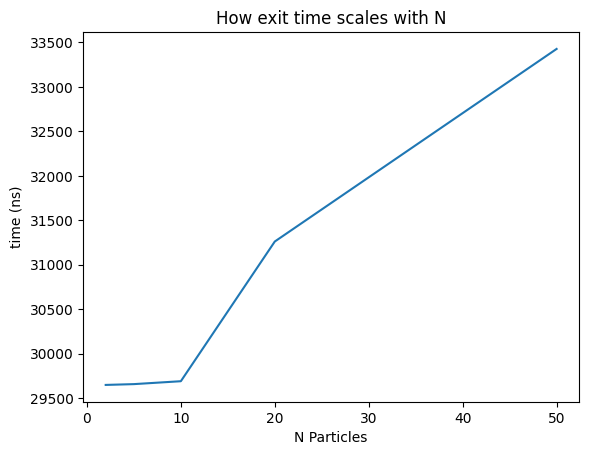

In [89]:
channel_length = 20
velocity_scale = 2
n_particles = 10
dt = 0.005
nsteps = 1000
frame_stride = 10
total_time = nsteps * dt
N = [2,5,10,20,50]
np.random.seed(42)
exit_time = []
for n in N:
  n_particles = n
  #random inital conditions and velocities for n_particles
  positions = np.random.uniform(1.0, channel_length-1.0, size=n_particles)
  velocities = np.random.normal(scale=velocity_scale, size=n_particles)
  particle_ids = np.arange(n_particles)

  # store trajectories for each particle id
  trajectories = {pid: [] for pid in particle_ids}
  time = []

  # --- Run simulation ---
  while len(positions) > 0:
      step += 1
      t = step * dt
      time.append(t)

      for pid, pos in zip(particle_ids, positions):
          trajectories[pid].append(pos)

      positions += velocities * dt

      # elastic collisions (equal mass)
      N = len(positions)
      for i in range(N):
          for j in range(i+1, N):
              if abs(positions[i] - positions[j]) < 1e-3:
                  velocities[i], velocities[j] = velocities[j], velocities[i]

      # vanish at walls
      outside = (positions <= 0.0) | (positions >= channel_length)
      if np.any(outside):
          keep = ~outside
          positions = positions[keep]
          velocities = velocities[keep]
          particle_ids = particle_ids[keep]
  exit_time.append(t)
#print(len(exit_time),len(N))
N = [2,5,10,20,50]
plt.plot(N,exit_time)
plt.xlabel("N Particles")
plt.ylabel("time (ns)")
plt.title("How exit time scales with N")
plt.show()

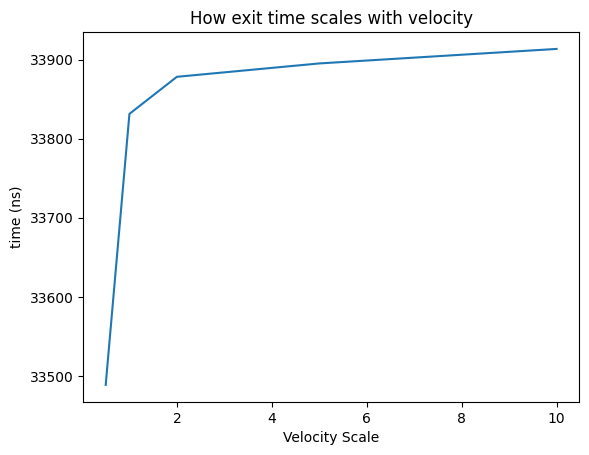

In [90]:
channel_length = 20
velocity_scale = 2
n_particles = 10
dt = 0.005
nsteps = 1000
frame_stride = 10
total_time = nsteps * dt
v = [0.5,1,2,5,10]
# @title Modified Simulation Code  { display-mode: "form" }
np.random.seed(42)
exit_time = []
for n in v:
  velocity_scale = n
  #random inital conditions and velocities for n_particles
  positions = np.random.uniform(1.0, channel_length-1.0, size=n_particles)
  velocities = np.random.normal(scale=velocity_scale, size=n_particles)
  particle_ids = np.arange(n_particles)

  # store trajectories for each particle id
  trajectories = {pid: [] for pid in particle_ids}
  time = []

  # --- Run simulation ---
  while len(positions) > 0:
      step += 1
      t = step * dt
      time.append(t)

      for pid, pos in zip(particle_ids, positions):
          trajectories[pid].append(pos)

      positions += velocities * dt

      # elastic collisions (equal mass)
      N = len(positions)
      for i in range(N):
          for j in range(i+1, N):
              if abs(positions[i] - positions[j]) < 1e-2:
                  velocities[i], velocities[j] = velocities[j], velocities[i]

      # vanish at walls
      outside = (positions <= 0.0) | (positions >= channel_length)
      if np.any(outside):
          keep = ~outside
          positions = positions[keep]
          velocities = velocities[keep]
          particle_ids = particle_ids[keep]
  exit_time.append(t)
#print(len(exit_time),len(N))
v = [0.5,1,2,5,10]
plt.plot(v,exit_time)
plt.xlabel("Velocity Scale")
plt.ylabel("time (ns)")
plt.title("How exit time scales with velocity")
plt.show()

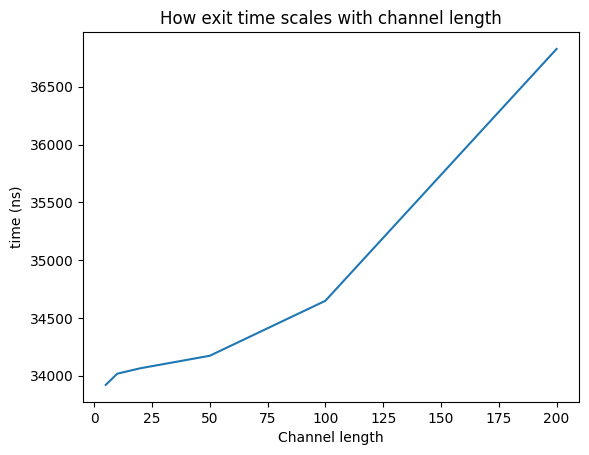

In [91]:
channel_length = 20
velocity_scale = 2
n_particles = 10
dt = 0.005
nsteps = 1000
frame_stride = 10
total_time = nsteps * dt
channel = [5,10,20,50,100,200]
# @title Modified Simulation Code  { display-mode: "form" }
np.random.seed(42)
exit_time = []
for n in channel:
  channel_length = n
  #random inital conditions and velocities for n_particles
  positions = np.random.uniform(1.0, channel_length-1.0, size=n_particles)
  velocities = np.random.normal(scale=velocity_scale, size=n_particles)
  particle_ids = np.arange(n_particles)

  # store trajectories for each particle id
  trajectories = {pid: [] for pid in particle_ids}
  time = []

  # --- Run simulation ---
  while len(positions) > 0:
      step += 1
      t = step * dt
      time.append(t)

      for pid, pos in zip(particle_ids, positions):
          trajectories[pid].append(pos)

      positions += velocities * dt

      # elastic collisions (equal mass)
      N = len(positions)
      for i in range(N):
          for j in range(i+1, N):
              if abs(positions[i] - positions[j]) < 1e-2:
                  velocities[i], velocities[j] = velocities[j], velocities[i]

      # vanish at walls
      outside = (positions <= 0.0) | (positions >= channel_length)
      if np.any(outside):
          keep = ~outside
          positions = positions[keep]
          velocities = velocities[keep]
          particle_ids = particle_ids[keep]
  exit_time.append(t)
#print(len(exit_time),len(N))
channel = [5,10,20,50,100,200]
plt.plot(channel,exit_time)
plt.xlabel("Channel length")
plt.ylabel("time (ns)")
plt.title("How exit time scales with channel length")
plt.show()